In [1]:
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from rembg import remove

from skimage import io
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage import img_as_ubyte, img_as_float

from skimage.morphology import dilation
from skimage.morphology import rectangle
from skimage.measure import label, regionprops

from utils import functions as F

## Defining functions

In [17]:
def cv_seg(img):
    # ret, thresh = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
    # ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_TRIANGLE)

    return thresh


def denoise(img):
    float_img = img_as_float(img)
    sigma_est = np.mean(estimate_sigma(img, channel_axis=-1))
    denoise_img = denoise_nl_means(float_img, h=1.15 * sigma_est, fast_mode=True, 
                               patch_size=5, patch_distance=3, channel_axis=-1)
    denoise_img_as_8byte = img_as_ubyte(denoise_img)
    # gray = cv2.cvtColor(denoise_img_as_8byte, cv2.COLOR_BGR2GRAY)
    return denoise_img_as_8byte


def multi_dil(im,num):
    for i in range(num):
        im = dilation(im)
    return im


def crop(img_path, final_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (512, 512), interpolation=cv2.INTER_AREA)
    rembg_img = remove(img)
    denoised = denoise(rembg_img)
    gray = cv2.cvtColor(denoised, cv2.COLOR_BGR2GRAY)
    segmented = cv_seg(gray)
    dilated = multi_dil(segmented, 3)
    label_im = label(segmented)
    for num, i in enumerate(regionprops(label_im)):
        minr, minc, maxr, maxc = i.bbox
        roi = denoised[minr:maxr, minc:maxc]
        cv2.imwrite(final_path + f"{num}.jpg", roi)


def erase_dir(folder):
    """ Deletes all files inside given folder
    
    ----------------------
    Parameters

        folder: string
            path to the folder to be emptied 

    ----------------------
    Returns

        None

    """

    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)

        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))


def hist(img):
    """ Calculates 3 channels color histogram with bins=256 
        
    ----------------------
    Parameters

        img: numpy.ndarray
            input image

    ----------------------
    Returns

        numpy.ndarray
            numpy array with shape (h, w, 3)

    """
    hist1 = cv2.calcHist([img],[0],None,[256],[0,256])
    hist2 = cv2.calcHist([img],[1],None,[256],[0,256])
    hist3 = cv2.calcHist([img],[2],None,[256],[0,256])
    

    return np.array([np.squeeze(hist1), np.squeeze(hist2), np.squeeze(hist3)])




def shape_distance(A, B):
    """ Calculates the proximity between two images' shape. Higher values
    corresponds to closer shapes. In this case, the image is the cropped 
    object

    ----------------------
    Parameters

        A: numpy.ndarray
            base object
        
        B: numpy.ndarray
            cropped object to be verified
    
    ----------------------
    Returns

        float
            Mean between the height and width ratio. A value 
            between 0 and 1 measuring how close the shapes are
    
    """
    A_shape = A.shape[:2]
    B_shape = B.shape[:2]
    height_ratio = 1 - abs((B_shape[0] - A_shape[0]) / A_shape[0])
    width_ratio = 1 - abs((B_shape[1] - A_shape[1]) / A_shape[1])
    mean = (height_ratio + width_ratio) / 2
    return mean

## Defining base image

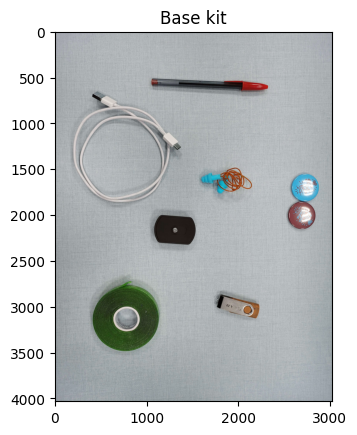

In [3]:
base_img_path = "./images/20230109_171941.jpg"

plt.imshow(cv2.imread(base_img_path))
plt.title("Base kit")

crop("./images/20230109_171941.jpg", "./base_img/")

### Label objects 
(not working yet), labelling manually

In [4]:
# objects_path = "./base_img/"
# objects = os.listdir(objects_path)
# objs = []

# for obj in objects:
#      img = cv2.imread(objects_path + obj)
#      plt.imshow("product", img)
#      name = input("Product name: ")
#      objs.append(name)
    
# print(objs)



In [5]:
objs = ["pen", "cable", "ear protector", "2 bottons", "black thing", "tape", "pen drive"]

objects_path = "./base_img/"
objects = os.listdir(objects_path)
base_imgs = []

for obj in objects:
     img = cv2.imread(objects_path + obj)
     base_imgs.append(img)

## Opening test images

In [44]:
image_path = "./images/"
extractions_path = "./extractions/"

images_list = os.listdir(image_path)

def verify_kit(test_img_path):
    actual_img = []
    # Clean extractions directory
    erase_dir(extractions_path)

    # Crop objects from test image
    crop(test_img_path, extractions_path)

    # List objects extracted
    extractions = os.listdir(extractions_path)

    # Iterate over objects extracted from test image
    for obj in extractions:
        test_img = cv2.imread(extractions_path + obj)
        aux = []  # stores the histograms distances
        for base_img in base_imgs:
            # Compare the shape from test object with every base object
            # and if the difference is below 7%, calculate distance 
            # between histograms
            if (shape_distance(base_img, test_img) >= 0.75):

                # Resize test image to base's size 
                base_shape = base_img.shape[:2]
                resized_test_img = cv2.resize(test_img, (base_shape[1], base_shape[0]), interpolation=cv2.INTER_AREA)

                # generate base and test images' histogram
                base_hist = hist(base_img)
                test_hist = hist(resized_test_img)

                # compare histograms and store into aux list
                res = cv2.compareHist(base_hist, test_hist, cv2.HISTCMP_BHATTACHARYYA) 
                aux.append(res)

            # stores 1 for images with different shape
            else:
                aux.append(1)
                
        # From histogram distances, the minimum value's index is used to locate the name of
        # the object from the list of names
        minimum = min(aux)
        index = aux.index(minimum)
        match = objs[index]
        if minimum != 1 and minimum <= 0.55:
            print(f"Match --> {match:8}: Distance = {minimum}")
            actual_img.append(match)

    # missing = [element for element in objs if element not in actual_img]
    print(f"missing objects: {list(element for element in objs if element not in actual_img)}")
                

### #1 test

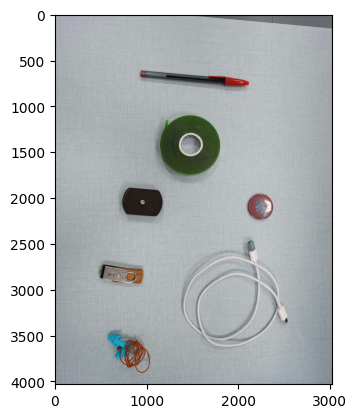

In [55]:
path = image_path + images_list[0]

plt.imshow(cv2.imread(path))


In [56]:
verify_kit(path)

Match --> pen     : Distance = 0.188131545239243
Match --> tape    : Distance = 0.20742788804965068
Match --> black thing: Distance = 0.21811232044022252
Match --> ear protector: Distance = 0.2740568364344681
Match --> cable   : Distance = 0.3377147500623945
Match --> pen drive: Distance = 0.42233273530306986
missing objects: ['2 bottons']


### #2 test

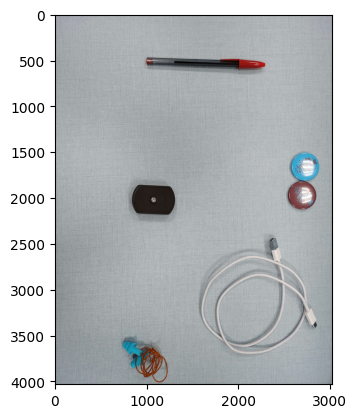

In [47]:
path = image_path + images_list[1]

plt.imshow(cv2.imread(path))


In [48]:
verify_kit(path)

Match --> pen     : Distance = 0.15507616133293506
Match --> 2 bottons: Distance = 0.1407764920195426
Match --> black thing: Distance = 0.17558905471261016
Match --> cable   : Distance = 0.3176938096319799
missing objects: ['ear protector', 'tape', 'pen drive']


### #3 test

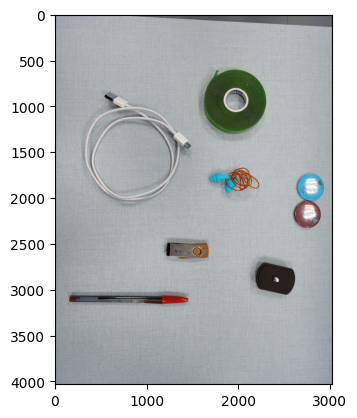

In [49]:
path = image_path + images_list[3]

plt.imshow(cv2.imread(path))


In [50]:
verify_kit(path)

Match --> tape    : Distance = 0.24633848770512903
Match --> cable   : Distance = 0.3077236502714549
Match --> ear protector: Distance = 0.24732609568515418
Match --> 2 bottons: Distance = 0.12133419674914002
Match --> pen drive: Distance = 0.4110656181363393
Match --> black thing: Distance = 0.4135480697873106
Match --> pen     : Distance = 0.2635280845319465
missing objects: []


### #4 first test

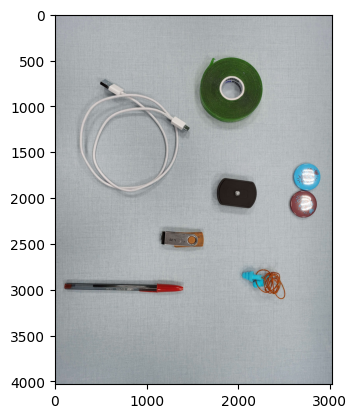

In [51]:
path = image_path + images_list[4]

plt.imshow(cv2.imread(path))


In [52]:
verify_kit(path)

Match --> tape    : Distance = 0.270896653992612
Match --> cable   : Distance = 0.1129195181495667
Match --> 2 bottons: Distance = 0.12462418245262061
Match --> black thing: Distance = 0.3900740439168818
Match --> pen drive: Distance = 0.44051534083500427
Match --> ear protector: Distance = 0.1524006231983829
Match --> pen     : Distance = 0.21872283716637764
missing objects: []


### #5 test

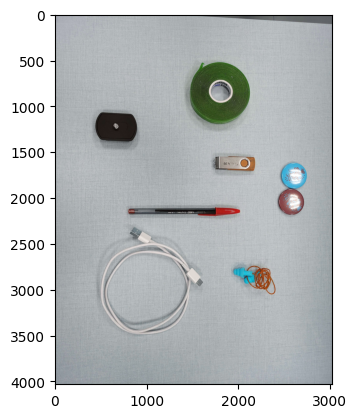

In [53]:
path = image_path + images_list[5]

plt.imshow(cv2.imread(path))


In [54]:
verify_kit(path)

Match --> tape    : Distance = 0.35219498359556534
Match --> black thing: Distance = 0.17807419264607022
Match --> pen drive: Distance = 0.36936636944047574
Match --> 2 bottons: Distance = 0.12132481376962144
Match --> pen     : Distance = 0.22140744490835895
Match --> cable   : Distance = 0.2797334366632594
Match --> ear protector: Distance = 0.1602910570187005
missing objects: []
